In [1]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [2]:
# Load the latest dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [3]:
# Manual feature selection

selected_features = [
  'news_count',
  'tanalysis_absa', 'economy_absa', 'regulation_absa', 
  'adoption_absa', 'cybersecurity_absa', 'technology_absa',
  'tanalysis_absa_ewm_100h', 'economy_absa_ewm_100h',
  'regulation_absa_ewm_100h', 'technology_absa_ewm_100h',
  'adoption_absa_ewm_100h', 'cybersecurity_absa_ewm_100h',

  'reddit_total_sentiment_ewm_2h',
  'reddit_average_sentiment_ewm_100h',

  'topic_exchange traded funds, ETF_last3',
  'topic_institutional investments_last3',
  'topic_market sentiment_last3',
  'topic_price action, price movement, trading_last3',

  "source_Coindesk_last3",  
  "source_Cointelegraph_last3",  
  "source_Bitcoin Magazine_last3",  
  "source_Benzinga_last3",  
  "source_The Daily Hodl_last3",  

  "NER_blackrock_last3",  
  "NER_sec_last3",  
  "NER_fed_last3",  
  "NER_grayscale_last3",  
  "NER_binance_last3",  
  "NER_coinbase_last3",  
  "NER_microstrategy_last3",  
  "NER_michael saylor_last3",

  "pct_b_10",
  "sma_20_50_diff",
  "atr_14",
  "atr_ratio",
  "atr_7_chg",
  "20_band_width",
  "rsi_ratio",
  "20_band_width"
]

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[selected_features]
y_train = df_train['target']
X_test = df_test[selected_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

X_train shape: (26274, 40)
y_train shape: (26274,)
X_test shape: (8784, 40)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### RandomForestClassifier Model with GridSearchCV

In [4]:
# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample', # Good for imbalanced data with RF
    n_jobs=-1 # Use all cores for fitting individual trees
  ))
])

# Parameter grid for GridSearchCV
param_grid = {
  'model__n_estimators': [50, 100, 200],
  'model__max_depth': [15, 20, 25],
  'model__min_samples_split': [2, 4],
  'model__min_samples_leaf': [1, 2, 3, 5],
  'model__max_features': ['sqrt']
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=pipeline,
  param_grid=param_grid,
  cv=tscv,
  scoring='roc_auc_ovr', # Use One-vs-Rest ROC AUC for multiclass
  n_jobs=-1,             # Use all available CPU cores for CV folds
  verbose=2              # Show progress
)

# Fit GridSearchCV on the training data
print("Starting GridSearchCV for RandomForestClassifier...")
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation ROC AUC score: ", grid_search.best_score_)

# Get the best estimator found by GridSearchCV
best_model = grid_search.best_estimator_

Starting GridSearchCV for RandomForestClassifier...
Fitting 5 folds for each of 72 candidates, totalling 360 fits

GridSearchCV fitting time: 281.19 seconds
Best parameters found:  {'model__max_depth': 25, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Best cross-validation ROC AUC score:  0.5809027640533861


### Feature Importance Analysis


Top 20 most important features:
                              Feature  Importance
34                             atr_14    0.083919
37                      20_band_width    0.061800
39                      20_band_width    0.060148
35                          atr_ratio    0.053538
32                           pct_b_10    0.052898
36                          atr_7_chg    0.049128
38                          rsi_ratio    0.048754
33                     sma_20_50_diff    0.047667
14  reddit_average_sentiment_ewm_100h    0.044929
13      reddit_total_sentiment_ewm_2h    0.043538
8               economy_absa_ewm_100h    0.041904
9            regulation_absa_ewm_100h    0.041843
7             tanalysis_absa_ewm_100h    0.041643
10           technology_absa_ewm_100h    0.040971
11             adoption_absa_ewm_100h    0.040929
12        cybersecurity_absa_ewm_100h    0.039989
1                      tanalysis_absa    0.034352
4                       adoption_absa    0.030320
0                

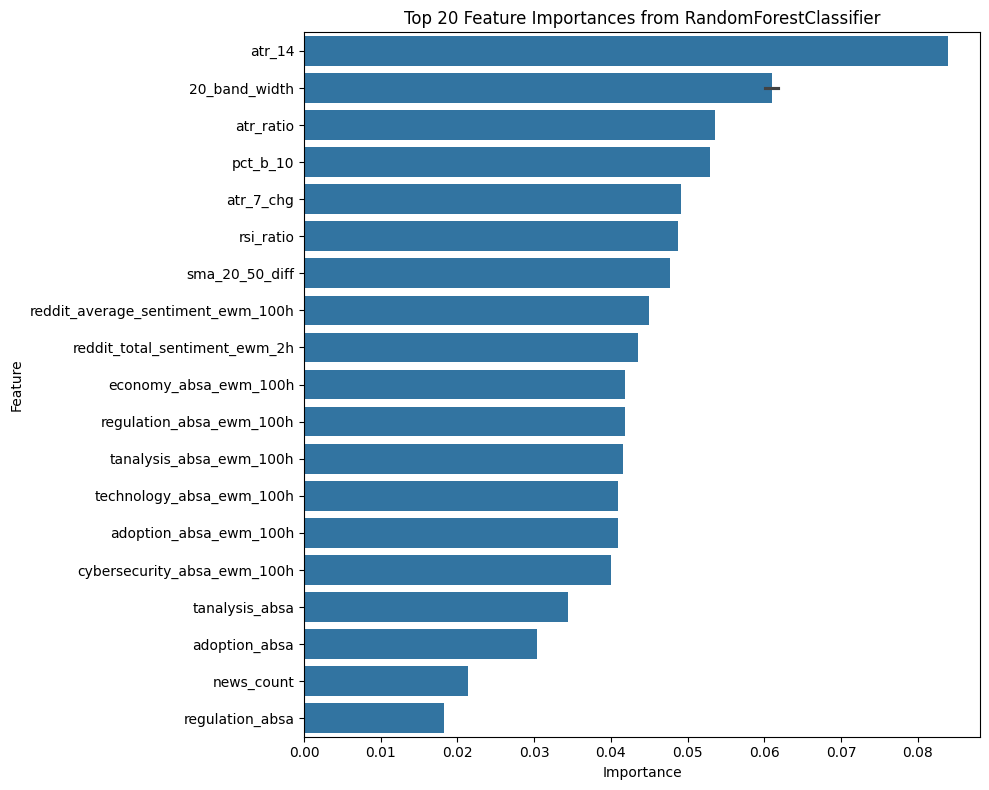

In [5]:
# Get feature importances from the best RandomForest model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from RandomForestClassifier')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.4851
ROC AUC Score (One-vs-Rest): 0.6890

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.39      0.43      0.41      2648
 Neutral (1)       0.78      0.46      0.58      3274
 Bullish (2)       0.41      0.56      0.48      2862

    accuracy                           0.49      8784
   macro avg       0.53      0.48      0.49      8784
weighted avg       0.54      0.49      0.49      8784


Confusion Matrix:
[[1146  198 1304]
 [ 788 1510  976]
 [1031  226 1605]]


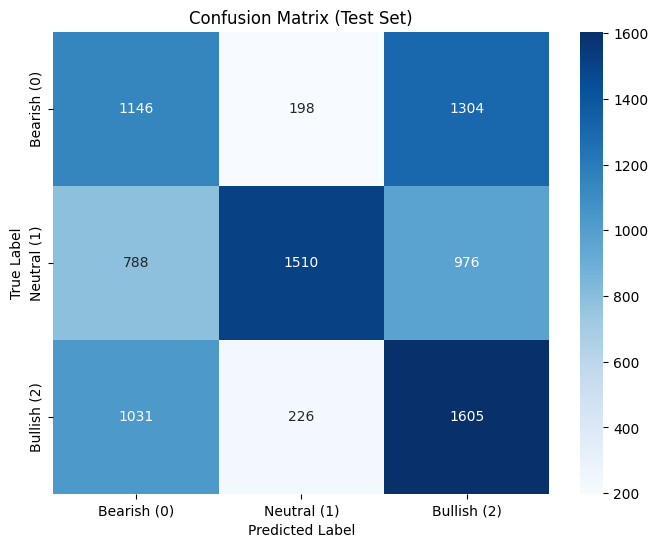

In [6]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.408602
2024-02-29    0.419540
2024-03-31    0.465054
2024-04-30    0.437500
2024-05-31    0.403226
2024-06-30    0.423611
2024-07-31    0.409946
2024-08-31    0.430108
2024-09-30    0.537500
2024-10-31    0.692204
2024-11-30    0.608333
2024-12-31    0.583333
Freq: ME, Name: correct_prediction, dtype: float64


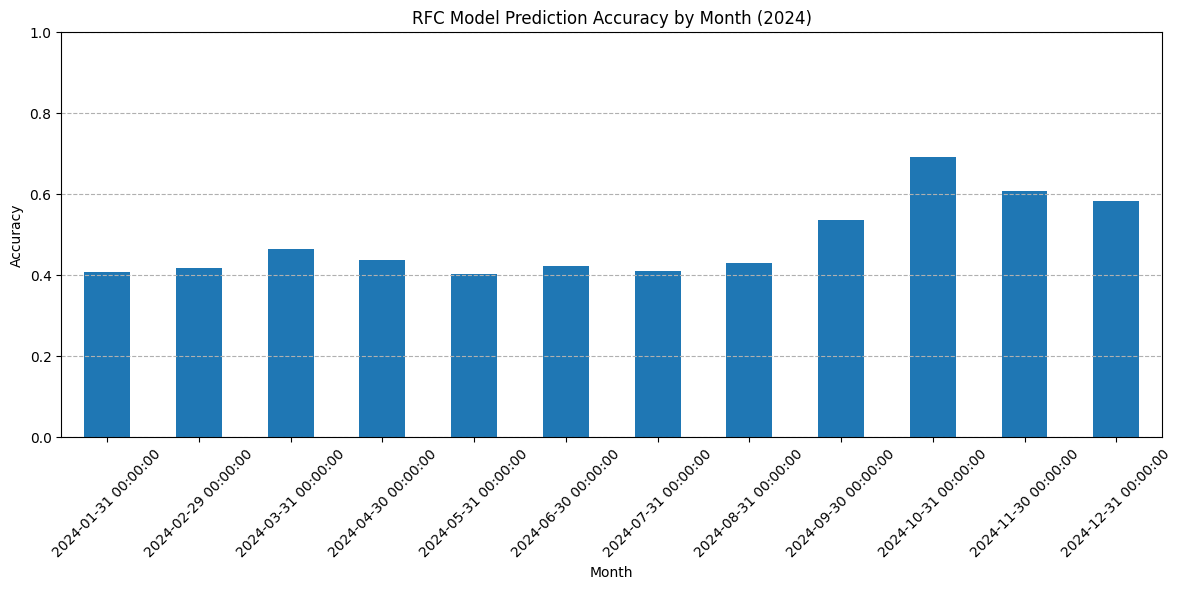


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                1      Bearish         Neutral   
2024-01-01 01:00:00       1                1      Neutral         Neutral   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                2      Neutral         Bullish   
2024-01-01 04:00:00       2                2      Bullish         Bullish   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.359687      0.394073      0.246240  
2024-01-01 01:00:00      0.311893      0.432846      0.255262  
2024-01-01 02:00:00      0.302126      0.380440      0.317435  
2024-01-01 03:00:00      0.270747      0.236627      0.492626  
2024-01-01 04:00:00      0.257772      0.265069      0.477159  


In [7]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('RFC Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy

Sample signals for backtesting:
                     target  predicted_class  signal
2024-01-01 00:00:00       0                1       0
2024-01-01 01:00:00       1                1       0
2024-01-01 02:00:00       0                1       0
2024-01-01 03:00:00       1                2       1
2024-01-01 04:00:00       2                2       1

Predicted signal distribution for backtest:
signal
 1    3885
-1    2965
 0    1934
Name: count, dtype: int64
Overall Annual Return: 150.11%
Overall Annual Sharpe Ratio: 2.1104
Maximum Drawdown: -18.71 %
Alpha: 1.3253
Beta: 0.2083

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       1.501145     0.49174     0.208251      0.843897       2.110375


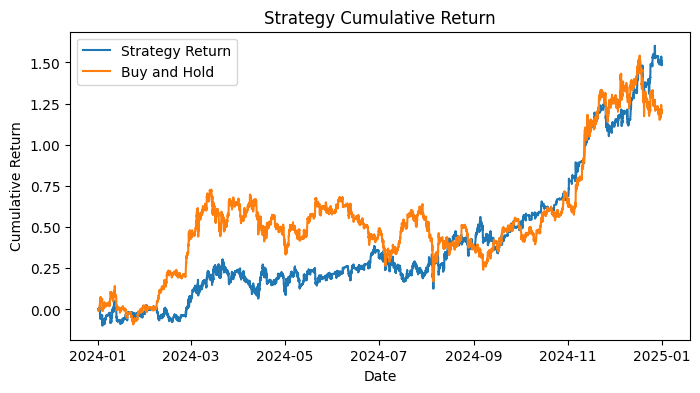

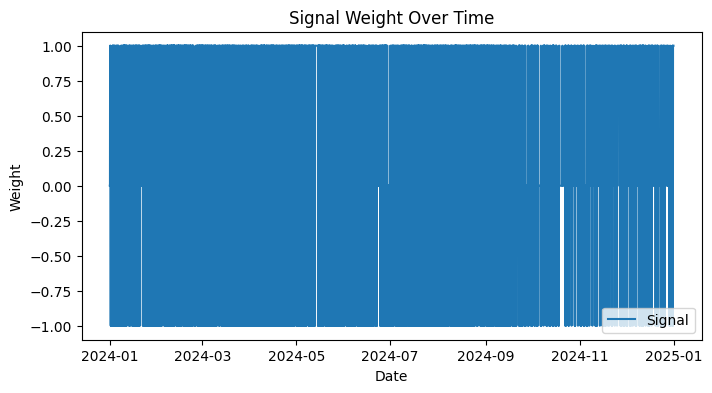

In [8]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# Display the first few rows with the new signal column
print("Sample signals for backtesting:")
print(df_backtest[['target', 'predicted_class', 'signal']].head())

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())

run_backtest(df_backtest, freq='h')